## Notebook to browse the replicated eQTL result for risk variants

In [1]:
!date

Wed Jul 14 22:13:24 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import concurrent.futures
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# parameters
disc_cohort = 'ppmi'
rep_cohort = 'pdbp'
tissue = 'wb'

In [4]:
# naming
cohort_build = f'{disc_cohort}.{rep_cohort}'

# directories
home_dir = '/home/jupyter'
wrk_dir = f'{home_dir}/{disc_cohort}'
genos_dir = f'{wrk_dir}/genotypes'
tensorqtl_dir = f'{wrk_dir}/tensorqtl'
results_dir = f'{wrk_dir}/results'
gwas_dir = f'{home_dir}/gwas'

# input files
gencode_pkl = f'{home_dir}/amppd/expression/gencode.v29.primary_assembly.annotation.pkl'
eqtl_results_file = f'{results_dir}/{cohort_build}.replicated.wb.cis.csv'
meta5_st2_clean_file = f'{gwas_dir}/pd.table_s2.clean.txt'
meta5_stats_file = f'{gwas_dir}/pdmeta_sumstats_hg38.h5'

# output files

# constant values
autosomes = [str(x) for x in list(range(1,23))]
alpha_value = 0.05
capture_out = !(nproc)
max_threads = int(capture_out[0])


#### analysis functions

In [5]:
def mixed_model(formula, df, group_name):
    model = sm.MixedLM.from_formula(formula, df, groups=df[group_name])
    result = model.fit()
    return result

def regress_tscores_keep(this_df):
    ret_value = False
    # run the regression, mixed effects model with visit as random effect
    this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs'
    grouping = 'month'
    result = mixed_model(this_formula, this_df, grouping)
#     print(result.summary())
    term = 'eqtl_tscore_abs'
#     print(['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
#     print(result.params[term], result.bse[term], 
#           result.params.shape[0], result.pvalues[term])    
    return [result.params[term], result.bse[term], 
            result.params.shape[0], result.pvalues[term]]

def create_merged_df_to_regress(eqtl_df, pheno_id, gwas_df):
    pheno_df = eqtl_df.loc[eqtl_df['phenotype_id'] == pheno_id]
    merged_df = pheno_df.merge(gwas_df, how='inner', 
                               left_on='variant_id', right_on='SNP')
    # will test regression on absolute t-score instead of say p-value
    merged_df['month'] =  merged_df['month'].astype(object)
    merged_df['gwas_tscore_abs'] = np.abs(merged_df['b']/merged_df['se'])
    merged_df['eqtl_tscore_abs'] = np.abs(merged_df['slope']/merged_df['slope_se'])

    # for regression will only consider variants that are nominally
    # significant in gwas or eqtl
    df_to_return = merged_df.loc[(merged_df['pval_nominal'] < alpha_value) | 
                                 (merged_df['p'] < alpha_value)]
    #     print(pheno_df.shape, merged_df.shape, alpha_df.shape)
    return df_to_return

def load_chrom_result(chrom, visits, in_dir, cohort, tissue):
    # have to do pass to find all phenos to possible capture
    df_to_return = None
    phenos_oi = []
    for visit in visits:
        chrom_file = f'{in_dir}/{cohort}.{tissue}{visit}.cis_qtl_pairs.chr{chrom}.parquet'
        chrom_eqtl_df = pd.read_parquet(chrom_file)
        oi_chrom_eqtl_df = chrom_eqtl_df.loc[chrom_eqtl_df['pval_nominal'] < max_pvalue]
        oi_results = oi_chrom_eqtl_df.loc[oi_chrom_eqtl_df['variant_id'].isin(variants_oi_df['SNP'])]
        phenos_oi = phenos_oi + list(oi_results['phenotype_id'].unique())

    # do pass to keep results that belong those phenos
    for visit in visits:
        chrom_file = f'{in_dir}/{cohort}.{tissue}{visit}.cis_qtl_pairs.chr{chrom}.parquet'
        chrom_eqtl_df = pd.read_parquet(chrom_file)
        possible_results_oi = chrom_eqtl_df.loc[chrom_eqtl_df['phenotype_id'].isin(phenos_oi)].copy()
        possible_results_oi['month'] = visit
        df_to_return = pd.concat([df_to_return, possible_results_oi])
    return phenos_oi, df_to_return

def process_regression_check(chrom, visits, in_dir, cohort, tissue, gwas_df):
    results_to_keep = None
    phenos_oi, results_to_test = load_chrom_result(chrom, visits, in_dir, cohort, tissue)
    print(f'chr {chrom} shape {results_to_test.shape}')
    # display(results_to_test.sample(5))

    # test the GWAS~eQTL regression for possible significance
    for phenotype_id in phenos_oi:
        alpha_df = create_merged_df_to_regress(results_to_test, phenotype_id, gwas_df)
        
        # ['coef', 'stderr', 'term_cnt', 'p-value']
        ret_vals = regress_tscores_keep(alpha_df)
        # must have postive coefficient and nomically significant p-value
        if ret_vals[0] > 0 and ret_vals[3] < alpha_value:
            results_to_keep = pd.concat([results_to_keep, alpha_df])
            
#         if phenotype_id == 'ENSG00000117280.12':
#             print(ret_vals)
    return results_to_keep

#### load the gencode annotations

In [6]:
%%time
gencode_df = pd.read_pickle(gencode_pkl)
# drop the ont and tag columns
discard_cols = gencode_df.columns[(gencode_df.columns.str.startswith('ont:')) |
                                (gencode_df.columns.str.startswith('tag:'))]
gencode_df.drop(columns=discard_cols, inplace=True)
# should only be autosomal but sometimes annotation quirks allow in others, so force
gencode_df = gencode_df.loc[(gencode_df['seqname'].str.startswith('chr')) & 
                           (~gencode_df['seqname'].isin(['chrX','chrY','chrM']))]
# every now and again having problem with mics_RNA genes mapping every chrom so drop
gencode_df = gencode_df.loc[~gencode_df['gene_type'].isin(['misc_RNA'])]
print(gencode_df.shape)
display(gencode_df.head())

(2636995, 22)


,seqname,source,feature,start,end,score,strand,frame,ccdsid,exon_id,...,gene_name,gene_type,havana_gene,havana_transcript,level,protein_id,transcript_id,transcript_name,transcript_support_level,transcript_type
0,chr1,HAVANA,gene,11869,14409,.,+,.,NaN,NaN,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,NaN,2,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11869,14409,.,+,.,NaN,NaN,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
2,chr1,HAVANA,exon,11869,12227,.,+,.,NaN,ENSE00002234944.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
3,chr1,HAVANA,exon,12613,12721,.,+,.,NaN,ENSE00003582793.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
4,chr1,HAVANA,exon,13221,14409,.,+,.,NaN,ENSE00002312635.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript


CPU times: user 5.87 s, sys: 2.16 s, total: 8.03 s
Wall time: 8.02 s


#### load the risk variants of interest

In [7]:
variants_oi_df = pd.read_csv(meta5_st2_clean_file, sep='\t')
print(variants_oi_df.shape)
variants_oi_df.head()

(91, 12)


,SNP,CHR,BP,Nearest_Gene,QTL_Nominated_Gene,Effect_allele,Other_allele,EAF,Beta_all_studies,SE_all_studies,P_all_studies,P_COJO_all_studies
0,rs114138760,1,154898185,PMVK,NaN,c,g,0.0112,0.2812,0.0478,4.190000e-09,1.090000e-08
1,rs35749011,1,155135036,KRTCAP2,EFNA3,a,g,0.0169,0.6068,0.0342,1.720000e-70,3.820000e-77
2,rs76763715,1,155205634,GBAP1,NaN,t,c,0.9953,-0.7467,0.0765,1.590000e-22,9.900000e-23
3,rs6658353,1,161469054,FCGR2A,FCGR2A,c,g,0.5011,0.0650,0.0094,6.100000e-12,4.690000e-12
4,rs11578699,1,171719769,VAMP4,VAMP4,t,c,0.1949,-0.0704,0.0120,4.470000e-09,4.450000e-09


#### load the full gwas summary stats

In [8]:
%%time
gwas_stats_df = pd.read_hdf(meta5_stats_file)
print(gwas_stats_df.shape)
display(gwas_stats_df.sample(5))

(7769022, 11)


,SNP,A1,A2,freq,b,se,p,N,chr,position,id
5816963,rs62346079,A,G,0.8245,0.0131,0.0137,0.3406,1460059,chr5,26773072,rs62346079
2416262,rs66878562,A,G,0.2680,0.0046,0.0117,0.6956,1460059,chr18,3101099,rs66878562
668866,rs11607366,T,C,0.0244,0.0555,0.0388,0.1529,1474097,chr11,64808297,rs11607366
4911504,rs6773338,A,C,0.4072,0.0075,0.0101,0.4574,1460059,chr3,82498824,rs6773338
5830894,rs10052634,A,C,0.9662,-0.0322,0.0291,0.2688,1460059,chr5,30547400,rs10052634


CPU times: user 25.6 s, sys: 1.99 s, total: 27.6 s
Wall time: 27.6 s


#### load the replicated eQTL

In [9]:
eqtl_df = pd.read_csv(eqtl_results_file)
print(eqtl_df.shape)
number_genes = len(eqtl_df['phenotype_id'].unique())
print(f'replicated eqtl for {number_genes} genes')
eqtl_df.head()

(185980, 16)
replicated eqtl for 5859 genes


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort
0,ENSG00000259488.2,rs74011998,-27340,0.155201,335,370,0.0,1.647849,0.025320,ENSG00000259488.2:rs74011998,0,inf,65.07998,65.07998,1,ppmi
1,ENSG00000259488.2,rs76749119,-18988,0.155201,335,370,0.0,1.647849,0.025320,ENSG00000259488.2:rs76749119,0,inf,65.07998,65.07998,1,ppmi
2,ENSG00000166435.15,rs7105085,-90306,0.233221,497,556,0.0,1.477821,0.022189,ENSG00000166435.15:rs7105085,0,inf,66.60303,66.60303,1,ppmi
3,ENSG00000166435.15,rs4944963,-57064,0.234480,497,559,0.0,1.470023,0.021803,ENSG00000166435.15:rs4944963,0,inf,67.42204,67.42204,1,ppmi
4,ENSG00000166435.15,rs12419929,-48810,0.234060,497,558,0.0,1.473253,0.021874,ENSG00000166435.15:rs12419929,0,inf,67.35073,67.35073,1,ppmi


#### which visit are present in the results (typically will be all in cohort)

In [10]:
visits = sorted(list(eqtl_df.loc[eqtl_df['cohort'] == disc_cohort]['month'].unique()))
print(visits)

[0, 6, 12, 24, 36]


#### grab the max pval_nominal and max pval_beta

In [11]:
max_pvalue = eqtl_df[eqtl_df['is_sig'] == 1]['pval_nominal'].max()
print(f'max p-value: {max_pvalue}')

max p-value: 0.0089461493872825


#### see if any of the top significant results happen to be risk independent variants

In [12]:
def check_eqtls_for_variants(eqtl_df, variants_df, gencode_df):
    eqtl_variants_oi_df = eqtl_df.loc[eqtl_df['variant_id'].isin(variants_df['SNP'])]
    print(eqtl_variants_oi_df.shape)
    this_cnt = len(eqtl_variants_oi_df['variant_id'].unique())
    print(f'variants {this_cnt}')
    print(eqtl_variants_oi_df['variant_id'].unique())
    this_cnt = len(eqtl_variants_oi_df['phenotype_id'].unique())
    print(f'genes {this_cnt}')
    oi_genes = gencode_df.loc[gencode_df['gene_id'].isin(eqtl_variants_oi_df['phenotype_id']), 
                              ['gene_name']]['gene_name'].unique()
    print(oi_genes)
    return eqtl_variants_oi_df

In [13]:
risk_genes = check_eqtls_for_variants(eqtl_df, variants_oi_df, gencode_df)
if len(risk_genes) > 0:
    display(risk_genes.head())

(10, 16)
variants 1
['rs12600861']
genes 1
['CHRNB1']


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort
39936,ENSG00000170175.10,rs12600861,7241,0.349662,676,828,8.768964e-21,0.386147,0.040526,ENSG00000170175.10:rs12600861,0,20.057052,9.528369,NaN,1,pdbp
59742,ENSG00000170175.10,rs12600861,7241,0.335546,377,455,2.277589e-14,0.419061,0.053686,ENSG00000170175.10:rs12600861,24,13.642525,7.805702,7.805702,1,ppmi
72011,ENSG00000170175.10,rs12600861,7241,0.341545,436,513,6.257595e-12,0.379225,0.054279,ENSG00000170175.10:rs12600861,6,11.203593,6.986653,6.986653,1,ppmi
83943,ENSG00000170175.10,rs12600861,7241,0.327601,658,781,4.034873e-10,0.268727,0.042615,ENSG00000170175.10:rs12600861,0,9.394170,6.305950,6.305950,1,ppmi
91958,ENSG00000170175.10,rs12600861,7241,0.327416,275,332,4.055278e-09,0.387902,0.064777,ENSG00000170175.10:rs12600861,12,8.391979,5.988233,NaN,1,pdbp


#### now load rest of results and see if risk index variants are eQTL

In [14]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [15]:
%%time

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor(max_workers=max_threads*2) as ppe:
    for chrom in autosomes:
        fs_list.append(ppe.submit(process_regression_check, chrom, visits, 
                                  tensorqtl_dir, disc_cohort, tissue, gwas_stats_df))
# for future in concurrent.futures.as_completed(fs_list):
#     lm_results.append(future.result())

# # flatten the list
# results_to_keep = pd.concat([item for item in lm_results])

chr 1 shape (888096, 10)
chr 2 shape (225025, 10)
chr 3 shape (604996, 10)
chr 4 shape (692660, 10)
chr 5 shape (165980, 10)
chr 6 shape (1889035, 10)
chr 7 shape (376260, 10)
chr 8 shape (588217, 10)
chr 9 shape (100385, 10)
chr 10 shape (128459, 10)
chr 11 shape (186485, 10)
chr 12 shape (444800, 10)
chr 13 shape (118555, 10)
chr 14 shape (243565, 10)
chr 15 shape (65820, 10)
chr 16 shape (581462, 10)
chr 17 shape (1082086, 10)
chr 18 shape (58050, 10)
chr 20 shape (115970, 10)
chr 19 shape (116555, 10)
chr 21 shape (69230, 10)
chr 22 shape (0, 10)
CPU times: user 3min 54s, sys: 28.6 s, total: 4min 23s
Wall time: 20min 34s


In [16]:
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result())

# flatten the list
results_to_keep = pd.concat([item for item in lm_results])

In [17]:
print(results_to_keep.shape)
display(results_to_keep.sample(5))

(2125181, 23)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,month,...,freq,b,se,p,N,chr,position,id,gwas_tscore_abs,eqtl_tscore_abs
25448,ENSG00000114030.12,rs6794826,983457,0.119469,155,162,0.025707,0.183537,0.082098,24,...,0.1101,0.0061,0.0160,0.704700,1474097,chr3,123498402,rs6794826,0.381250,2.235594
20032,ENSG00000269293.2,rs386628,679326,0.461792,544,701,0.006073,0.141036,0.051256,12,...,0.5069,-0.0039,0.0096,0.683500,1471960,chr6,28816619,rs386628,0.406250,2.751595
3421,ENSG00000178252.17,rs3895736,-386028,0.161119,225,242,0.046704,0.124924,0.062703,6,...,0.1715,-0.0335,0.0126,0.007802,1474097,chr3,48621034,rs3895736,2.658730,1.992294
5875,ENSG00000120071.14,rs4968248,690373,0.373322,735,890,0.829173,-0.009301,0.043097,0,...,0.6135,0.0267,0.0097,0.005846,1474097,chr17,46915762,rs4968248,2.752577,0.215809
1272,ENSG00000176681.14,rs16941058,-598009,0.047431,70,72,0.034844,-0.259372,0.122692,12,...,0.9522,-0.0196,0.0271,0.468800,1471960,chr17,45694724,rs16941058,0.723247,2.113999


In [18]:
print(len(results_to_keep['phenotype_id'].unique()))
print(results_to_keep['phenotype_id'].unique())

73
['ENSG00000253200.1' 'ENSG00000241852.9' 'ENSG00000164733.20'
 'ENSG00000079459.12' 'ENSG00000154328.15' 'ENSG00000255495.1'
 'ENSG00000106610.15' 'ENSG00000136243.16' 'ENSG00000272831.1'
 'ENSG00000179406.7' 'ENSG00000122550.17' 'ENSG00000230042.1'
 'ENSG00000230658.1' 'ENSG00000266504.1' 'ENSG00000238723.1'
 'ENSG00000120071.14' 'ENSG00000233223.2' 'ENSG00000176681.14'
 'ENSG00000228696.8' 'ENSG00000214425.7' 'ENSG00000238083.7'
 'ENSG00000131484.4' 'ENSG00000170175.10' 'ENSG00000073969.18'
 'ENSG00000214401.4' 'ENSG00000185829.17' 'ENSG00000266918.1'
 'ENSG00000267198.1' 'ENSG00000204650.14' 'ENSG00000262633.2'
 'ENSG00000265411.1' 'ENSG00000232300.1' 'ENSG00000260075.1'
 'ENSG00000269293.2' 'ENSG00000272009.1' 'ENSG00000206503.12'
 'ENSG00000176476.8' 'ENSG00000169682.17' 'ENSG00000178952.10'
 'ENSG00000278133.1' 'ENSG00000103496.14' 'ENSG00000196502.11'
 'ENSG00000270120.1' 'ENSG00000260911.2' 'ENSG00000167207.13'
 'ENSG00000185905.3' 'ENSG00000177548.12' 'ENSG00000117280.12'
 

In [19]:
genes_kept  = gencode_df.loc[gencode_df['gene_id'].isin(results_to_keep['phenotype_id']), 
                             ['gene_name']]['gene_name'].unique()
print(len(genes_kept))
print(genes_kept)

71
['RAB29' 'MAL' 'ZNF514' 'LINC01127' 'STK39' 'ZNF589' 'NME6' 'ARIH2' 'WDR6'
 'IQCB1' 'KPNA1' 'P2RY14' 'AC092953.1' 'DGKQ' 'IDUA' 'DCAF16' 'LCORL'
 'ERCC8' 'NDUFAF2' 'PAM' 'GIN1' 'PPIP5K2' 'AL121944.1' 'ZSCAN16-AS1'
 'HLA-A' 'KLHL7-DT' 'KLHL7' 'AK3P3' 'NUPL2' 'LINC00174' 'AC027644.3'
 'STAG3L4' 'NEIL2' 'FDFT1' 'CTSB' 'AC145124.1' 'C8orf58' 'AC037459.3'
 'AC009464.1' 'HCAR3' 'SLC25A21' 'GPR65' 'SGF29' 'SULT1A1' 'TUFM' 'RABEP2'
 'SPNS1' 'C16orf54' 'STX4' 'AC135050.3' 'AC135050.6' 'NOD2' 'AC007728.3'
 'CHRNB1' 'AC016876.1' 'LRRC37A4P' 'AC091132.3' 'AC091132.1' 'AC091132.4'
 'RDM1P1' 'LINC02210' 'KANSL1' 'KANSL1-AS1' 'ARL17B' 'LRRC37A' 'NSFP1'
 'LRRC37A2' 'ARL17A' 'FAM215B' 'NSF' 'AC005670.2']


In [20]:
import random
phenotype_id = random.choice(results_to_keep['phenotype_id'].unique())
print(phenotype_id)

ENSG00000204650.14


In [21]:
gencode_df.loc[gencode_df['gene_id'] == phenotype_id, 
               ['gene_name']]['gene_name'].unique()

array(['LINC02210'], dtype=object)

In [22]:
# phenotype_id = 'ENSG00000143537.13'
# phenotype_id = 'ENSG00000164733.20'
temp = results_to_keep.loc[results_to_keep['phenotype_id'] == phenotype_id]
print(temp.shape)
display(temp.head())

(29750, 23)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,month,...,freq,b,se,p,N,chr,position,id,gwas_tscore_abs,eqtl_tscore_abs
0,ENSG00000204650.14,rs7502699,-999887,0.383389,742,914,0.801418,0.009421,0.037451,0,...,0.648,-0.0378,0.0102,0.0002,1474097,chr17,44620441,rs7502699,3.705882,0.251568
1,ENSG00000204650.14,rs7502699,-999887,0.385486,466,579,0.077209,0.080949,0.045745,6,...,0.648,-0.0378,0.0102,0.0002,1474097,chr17,44620441,rs7502699,3.705882,1.769568
2,ENSG00000204650.14,rs7502699,-999887,0.390646,475,593,0.092729,-0.079786,0.047398,12,...,0.648,-0.0378,0.0102,0.0002,1474097,chr17,44620441,rs7502699,3.705882,1.683313
3,ENSG00000204650.14,rs7502699,-999887,0.388643,420,527,0.876236,-0.007854,0.050410,24,...,0.648,-0.0378,0.0102,0.0002,1474097,chr17,44620441,rs7502699,3.705882,0.155802
4,ENSG00000204650.14,rs7502699,-999887,0.366327,292,359,0.041389,-0.115030,0.056248,36,...,0.648,-0.0378,0.0102,0.0002,1474097,chr17,44620441,rs7502699,3.705882,2.045071


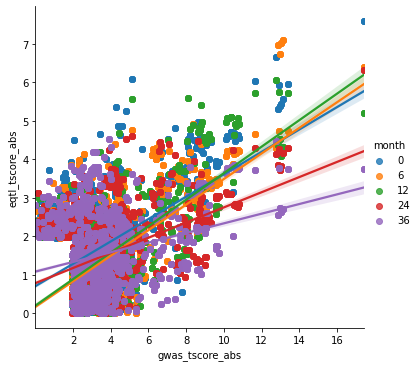

In [23]:
sns.lmplot(x='gwas_tscore_abs', y='eqtl_tscore_abs', hue='month', data=temp)

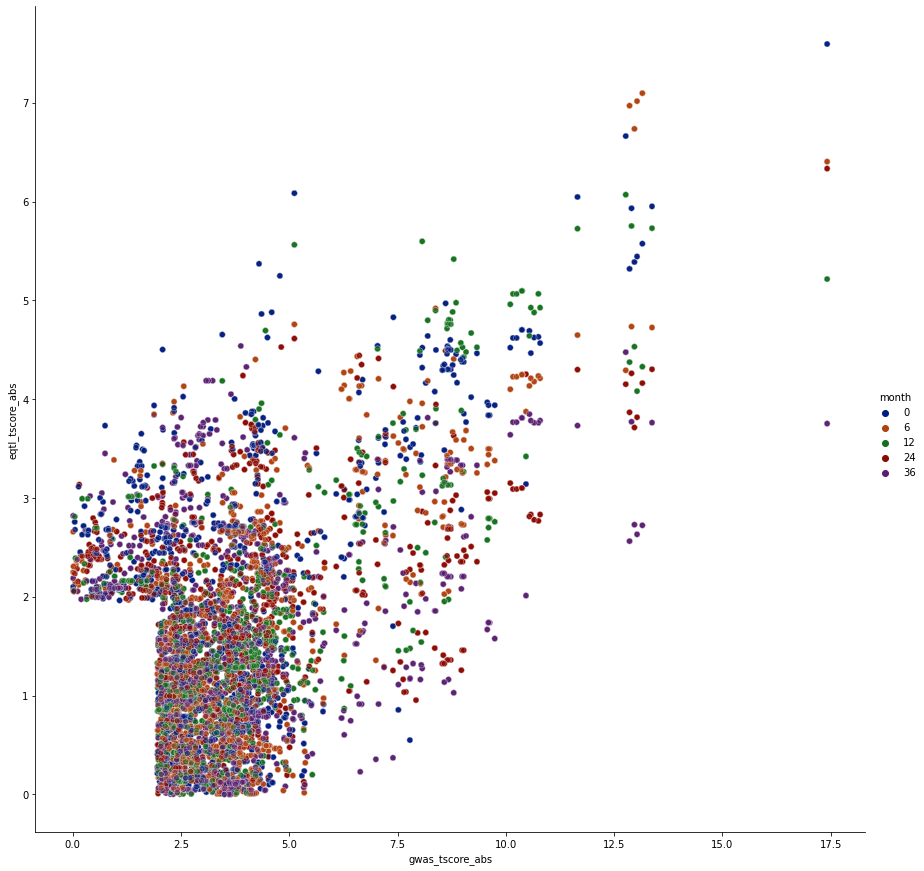

In [24]:
sns.relplot(x='gwas_tscore_abs', 
            y='eqtl_tscore_abs', 
            hue='month', alpha=.5, palette="dark", 
            height=12, data=temp) 

In [25]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs'
grouping = 'month'
result = mixed_model(this_formula, temp, grouping)
print(result.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: gwas_tscore_abs
No. Observations: 29750   Method:             REML           
No. Groups:       5       Scale:              3.0841         
Min. group size:  5780    Log-Likelihood:     -58982.1643    
Max. group size:  6210    Converged:          No             
Mean group size:  5950.0                                     
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           2.267    0.108 20.901 0.000  2.054  2.479
eqtl_tscore_abs     0.871    0.009 92.493 0.000  0.853  0.889
Group Var           0.057    0.091                           



In [26]:
term = 'eqtl_tscore_abs'
print(['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(result.params[term], result.bse[term], 
      result.params.shape[0], result.pvalues[term])

['feature', 'coef', 'stderr', 'term_cnt', 'p-value']
0.8709673390728015 0.009416617036155022 3 0.0


In [27]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gwas_tscore_abs   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     8303.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:34:44   Log-Likelihood:                -59083.
No. Observations:               29750   AIC:                         1.182e+05
Df Residuals:                   29748   BIC:                         1.182e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.2856      0.018    1

In [28]:
temp.columns

Index(['phenotype_id', 'variant_id', 'tss_distance', 'af', 'ma_samples',
       'ma_count', 'pval_nominal', 'slope', 'slope_se', 'month', 'SNP', 'A1',
       'A2', 'freq', 'b', 'se', 'p', 'N', 'chr', 'position', 'id',
       'gwas_tscore_abs', 'eqtl_tscore_abs'],
      dtype='object')

In [29]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs + month'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gwas_tscore_abs   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     1721.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:34:44   Log-Likelihood:                -58964.
No. Observations:               29750   AIC:                         1.179e+05
Df Residuals:                   29744   BIC:                         1.180e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9923      0.028     

In [30]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs + month + eqtl_tscore_abs * month'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gwas_tscore_abs   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1060.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:34:44   Log-Likelihood:                -58607.
No. Observations:               29750   AIC:                         1.172e+05
Df Residuals:                   29740   BIC:                         1.173e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [31]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs + (1|month)'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gwas_tscore_abs   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     8303.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:34:44   Log-Likelihood:                -59083.
No. Observations:               29750   AIC:                         1.182e+05
Df Residuals:                   29748   BIC:                         1.182e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.1428      0.00

#### now scan kept genes in the replication cohort

#### which visit are present in the results (typically will be all in cohort)

In [32]:
rep_visits = sorted(list(eqtl_df.loc[eqtl_df['cohort'] == rep_cohort]['month'].unique()))
print(rep_visits)

[0, 6, 12, 18, 24]


In [33]:
def load_pheno_result(ids, chrom, visits, in_dir, cohort, tissue):
    df_to_return = None
    for visit in visits:
        chrom_file = f'{in_dir}/{cohort}.{tissue}{visit}.cis_qtl_pairs.chr{chrom}.parquet'
        chrom_eqtl_df = pd.read_parquet(chrom_file)
        possible_results_oi = chrom_eqtl_df.loc[chrom_eqtl_df['phenotype_id'].isin(ids)].copy()
        possible_results_oi['month'] = visit
        df_to_return = pd.concat([df_to_return, possible_results_oi])
    return df_to_return

def process_replication_check(pheno_ids, chrom, visits, in_dir, cohort, tissue, gwas_df):
    results_to_keep = None
    results_to_test = load_pheno_result(pheno_ids, chrom, visits, in_dir, cohort, tissue)

    # test the GWAS~eQTL regression for possible significance
    phenos_oi = list(results_to_test['phenotype_id'].unique())
    print(f'chr {chrom} shape {results_to_test.shape} pheno-count {len(phenos_oi)}')
    for phenotype_id in phenos_oi:
        alpha_df = create_merged_df_to_regress(results_to_test, phenotype_id, gwas_df)

        if alpha_df.shape[0] > 0 and regress_tscores_keep(alpha_df):
            results_to_keep = pd.concat([results_to_keep, alpha_df])
    return results_to_keep

In [34]:
%%time

rep_tensorqtl_dir = f'{home_dir}/{rep_cohort}/tensorqtl'

pheno_ids = list(results_to_keep['phenotype_id'].unique())

rep_results_to_keep = None
for chrom in autosomes:
    chr_result = process_replication_check(pheno_ids, chrom, rep_visits, rep_tensorqtl_dir, 
                                           rep_cohort, tissue, gwas_stats_df)
    if not chr_result is None:
        rep_results_to_keep = pd.concat([rep_results_to_keep, chr_result])

print(rep_results_to_keep.shape)
display(rep_results_to_keep.sample(5))

chr 1 shape (27590, 10) pheno-count 1
chr 2 shape (74115, 10) pheno-count 4
chr 3 shape (149084, 10) pheno-count 8
chr 4 shape (130770, 10) pheno-count 4
chr 5 shape (145550, 10) pheno-count 5
chr 6 shape (91480, 10) pheno-count 2
chr 7 shape (237670, 10) pheno-count 7
chr 8 shape (131185, 10) pheno-count 5
chr 9 shape (0, 10) pheno-count 0
chr 10 shape (0, 10) pheno-count 0
chr 11 shape (0, 10) pheno-count 0
chr 12 shape (50575, 10) pheno-count 2
chr 13 shape (0, 10) pheno-count 0
chr 14 shape (58795, 10) pheno-count 2
chr 15 shape (0, 10) pheno-count 0
chr 16 shape (195770, 10) pheno-count 11
chr 17 shape (438850, 10) pheno-count 17
chr 18 shape (0, 10) pheno-count 0
chr 19 shape (0, 10) pheno-count 0
chr 20 shape (0, 10) pheno-count 0
chr 21 shape (0, 10) pheno-count 0
chr 22 shape (0, 10) pheno-count 0
(460684, 23)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,month,...,freq,b,se,p,N,chr,position,id,gwas_tscore_abs,eqtl_tscore_abs
13743,ENSG00000164733.20,rs35669118,-231120,0.165509,126,143,0.002294,0.253578,0.082658,18,...,0.1632,-0.0336,0.0135,0.012910,1474097,chr8,11638328,rs35669118,2.488889,3.067795
15746,ENSG00000127415.12,rs140159804,146623,0.027495,27,27,0.170992,-0.269086,0.196262,6,...,0.0274,-0.0683,0.0302,0.023900,1474097,chr4,1133620,rs140159804,2.261589,1.371059
16994,ENSG00000178177.15,rs2320572,237721,0.264706,189,216,0.156180,0.110444,0.077739,24,...,0.2823,0.0248,0.0116,0.032770,1460059,chr4,18259597,rs2320572,2.137931,1.420702
18490,ENSG00000206503.12,rs2394228,-68086,0.356841,702,845,0.000016,-0.180108,0.041566,0,...,0.3551,0.0103,0.0104,0.323400,1471960,chr6,29873174,rs2394228,0.990385,4.333020
5491,ENSG00000260911.2,rs7193943,216592,0.311609,261,306,0.309184,0.069066,0.067844,6,...,0.7010,0.0278,0.0104,0.007498,1474097,chr16,31259742,rs7193943,2.673077,1.018005


CPU times: user 16min 4s, sys: 46.2 s, total: 16min 50s
Wall time: 10min 39s


In [35]:
print(len(rep_results_to_keep['phenotype_id'].unique()))
print(rep_results_to_keep['phenotype_id'].unique())

68
['ENSG00000117280.12' 'ENSG00000198648.10' 'ENSG00000281162.2'
 'ENSG00000172005.10' 'ENSG00000144026.11' 'ENSG00000177479.19'
 'ENSG00000172113.9' 'ENSG00000114030.12' 'ENSG00000178252.17'
 'ENSG00000173226.16' 'ENSG00000164048.13' 'ENSG00000174944.8'
 'ENSG00000244346.1' 'ENSG00000163257.10' 'ENSG00000178177.15'
 'ENSG00000145214.13' 'ENSG00000127415.12' 'ENSG00000049167.14'
 'ENSG00000145730.20' 'ENSG00000145723.16' 'ENSG00000164182.10'
 'ENSG00000145725.19' 'ENSG00000206503.12' 'ENSG00000269293.2'
 'ENSG00000106610.15' 'ENSG00000230658.1' 'ENSG00000230042.1'
 'ENSG00000122550.17' 'ENSG00000136243.16' 'ENSG00000272831.1'
 'ENSG00000179406.7' 'ENSG00000253200.1' 'ENSG00000164733.20'
 'ENSG00000154328.15' 'ENSG00000079459.12' 'ENSG00000255495.1'
 'ENSG00000278475.1' 'ENSG00000255398.2' 'ENSG00000183032.11'
 'ENSG00000140030.5' 'ENSG00000270120.1' 'ENSG00000260911.2'
 'ENSG00000196502.11' 'ENSG00000167207.13' 'ENSG00000169682.17'
 'ENSG00000185905.3' 'ENSG00000103496.14' 'ENSG000002

In [36]:
rep_genes_kept  = gencode_df.loc[gencode_df['gene_id'].isin(rep_results_to_keep['phenotype_id']), 
                             ['gene_name']]['gene_name'].unique()
print(len(rep_genes_kept))
print(rep_genes_kept)

66
['RAB29' 'MAL' 'ZNF514' 'LINC01127' 'STK39' 'ZNF589' 'NME6' 'ARIH2' 'WDR6'
 'IQCB1' 'KPNA1' 'P2RY14' 'AC092953.1' 'DGKQ' 'IDUA' 'DCAF16' 'LCORL'
 'ERCC8' 'NDUFAF2' 'PAM' 'GIN1' 'PPIP5K2' 'ZSCAN16-AS1' 'HLA-A' 'KLHL7-DT'
 'KLHL7' 'AK3P3' 'NUPL2' 'LINC00174' 'AC027644.3' 'STAG3L4' 'NEIL2'
 'FDFT1' 'CTSB' 'AC145124.1' 'AC037459.3' 'AC009464.1' 'HCAR3' 'SLC25A21'
 'GPR65' 'SGF29' 'SULT1A1' 'TUFM' 'RABEP2' 'SPNS1' 'C16orf54' 'STX4'
 'AC135050.3' 'AC135050.6' 'NOD2' 'AC007728.3' 'CHRNB1' 'AC016876.1'
 'LRRC37A4P' 'AC091132.3' 'AC091132.4' 'RDM1P1' 'LINC02210' 'KANSL1'
 'KANSL1-AS1' 'ARL17B' 'LRRC37A' 'LRRC37A2' 'ARL17A' 'NSF' 'AC005670.2']


In [37]:
set(genes_kept) - set(rep_genes_kept)

{'AC091132.1', 'AL121944.1', 'C8orf58', 'FAM215B', 'NSFP1'}